In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler


In [9]:
import tensorflow as tf
if tf.__version__.startswith("2."):
  import tensorflow.compat.v1 as tf
  tf.compat.v1.disable_v2_behavior()
  tf.compat.v1.disable_eager_execution()

In [10]:
data = pd.read_csv('winequality-red.csv')
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [11]:
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm')

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,-0.256131,0.671703,0.114777,0.093705,-0.153794,-0.113181,0.668047,-0.682978,0.183006,-0.061668,0.124052
volatile acidity,-0.256131,1.000000,-0.552496,0.001918,0.061298,-0.010504,0.076470,0.022026,0.234937,-0.260987,-0.202288,-0.390558
citric acid,0.671703,-0.552496,1.000000,0.143577,0.203823,-0.060978,0.035533,0.364947,-0.541904,0.312770,0.109903,0.226373
residual sugar,0.114777,0.001918,0.143577,1.000000,0.055610,0.187049,0.203028,0.355283,-0.085652,0.005527,0.042075,0.013732
chlorides,0.093705,0.061298,0.203823,0.055610,1.000000,0.005562,0.047400,0.200632,-0.265026,0.371260,-0.221141,-0.128907
free sulfur dioxide,-0.153794,-0.010504,-0.060978,0.187049,0.005562,1.000000,0.667666,-0.021946,0.070377,0.051658,-0.069408,-0.050656
total sulfur dioxide,-0.113181,0.076470,0.035533,0.203028,0.047400,0.667666,1.000000,0.071269,-0.066495,0.042947,-0.205654,-0.185100
density,0.668047,0.022026,0.364947,0.355283,0.200632,-0.021946,0.071269,1.000000,-0.341699,0.148506,-0.496180,-0.174919
pH,-0.682978,0.234937,-0.541904,-0.085652,-0.265026,0.070377,-0.066495,-0.341699,1.000000,-0.196648,0.205633,-0.057731
sulphates,0.183006,-0.260987,0.312770,0.005527,0.371260,0.051658,0.042947,0.148506,-0.196648,1.000000,0.093595,0.251397


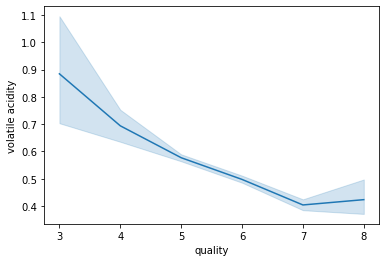

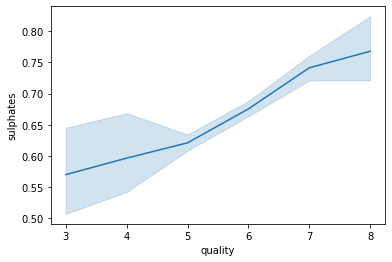

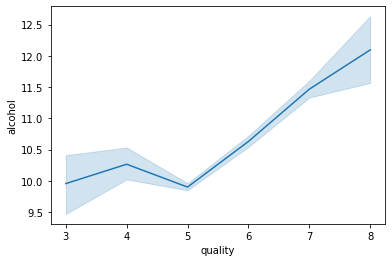

In [12]:
sns.lineplot(x=data["quality"], y=data["volatile acidity"])
plt.show()
sns.lineplot(x=data["quality"], y=data["sulphates"])
plt.show()
sns.lineplot(x=data["quality"], y=data["alcohol"])
plt.show()

In [13]:
data = data[["volatile acidity","sulphates","alcohol","quality"]].copy()
data.describe()

,volatile acidity,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000
mean,0.527821,0.658149,10.422983,5.636023
std,0.179060,0.169507,1.065668,0.807569
min,0.120000,0.330000,8.400000,3.000000
25%,0.390000,0.550000,9.500000,5.000000
50%,0.520000,0.620000,10.200000,6.000000
75%,0.640000,0.730000,11.100000,6.000000
max,1.580000,2.000000,14.900000,8.000000


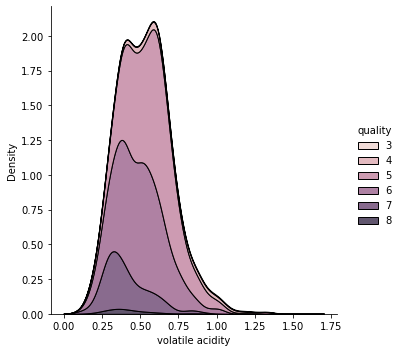

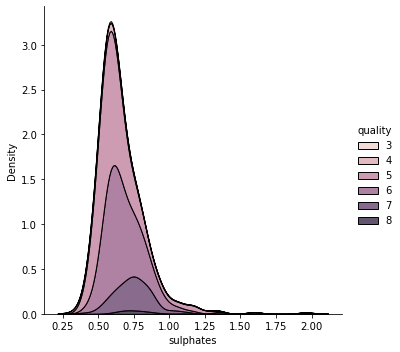

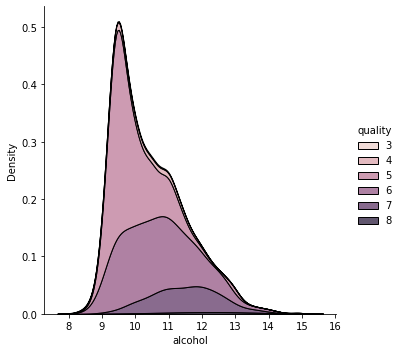

In [14]:
sns.displot(data, x="volatile acidity", hue="quality", kind="kde", multiple="stack")
sns.displot(data, x="sulphates", hue="quality", kind="kde", multiple="stack")
sns.displot(data, x="alcohol", hue="quality", kind="kde", multiple="stack")

In [36]:
data_y = np.array(data["quality"])
pol_features = PolynomialFeatures(degree=2)
data_x = pol_features.fit_transform(data[["volatile acidity","sulphates","alcohol"]])
print(pd.DataFrame(data_x).head())
print(pol_features.get_feature_names())

     0     1     2    3       4       5      6       7      8      9
0  1.0  0.70  0.56  9.4  0.4900  0.3920  6.580  0.3136  5.264  88.36
1  1.0  0.88  0.68  9.8  0.7744  0.5984  8.624  0.4624  6.664  96.04
2  1.0  0.76  0.65  9.8  0.5776  0.4940  7.448  0.4225  6.370  96.04
3  1.0  0.28  0.58  9.8  0.0784  0.1624  2.744  0.3364  5.684  96.04
4  1.0  0.70  0.56  9.4  0.4900  0.3920  6.580  0.3136  5.264  88.36
['1', 'x0', 'x1', 'x2', 'x0^2', 'x0 x1', 'x0 x2', 'x1^2', 'x1 x2', 'x2^2']


In [42]:
def FeatureEngineering(data, pol_degree, normalization=True):
    data_y = np.array(data["quality"])
    pol_features = PolynomialFeatures(degree=pol_degree)
    data_x = pol_features.fit_transform(data[["volatile acidity","sulphates","alcohol"]])
    if (normalization):
        scaler = StandardScaler().fit(data_x[:,1:])
        data_x_norm = np.hstack((data_x[:,0].reshape(-1,1),scaler.transform(data_x[:,1:]))).copy()
        return data_x_norm, data_y, pol_features, scaler
    return data_x, data_y, pol_features


In [18]:
def error(y, y_pred):
    return 1/2*tf.reduce_mean(tf.math.square(y - y_pred))

In [97]:
def TrainingModel(data, epochs, batch_size, lr, degree, normalization):
    if (normalization):
        dataX, dataY, pol_features, scaler = FeatureEngineering(data, degree, normalization)
    else:
        dataX, dataY, pol_features = FeatureEngineering(data, degree, normalization)
    
    tf.reset_default_graph()
    g = tf.Graph()
    with g.as_default():
        weights = tf.Variable(tf.zeros((np.shape(dataX)[1],1)), dtype=tf.float32, name = "weights")
        tensor_x = tf.placeholder(dtype=tf.float32,name="X")
        tensor_y = tf.placeholder(dtype=tf.float32,name="Y")
        tensor_lr = tf.placeholder(dtype=tf.float32,name="LR")

        with tf.name_scope("Model"):
            y_pred = tf.linalg.matmul(tensor_x,weights)
        with tf.name_scope("MSE"):
            MSE = error(tensor_y, y_pred)
            cost_summary = tf.summary.scalar("cost",MSE)
        with tf.name_scope("Gradient_Descent"):
            gradientes = tf.gradients(MSE,weights, name="Gradients")
            actualizacion_parametros = tf.assign(weights,weights - tensor_lr*gradientes[0]
            ,name="Parameters_Update")

        total_iteraciones = int(dataX.size/batch_size)
    
        with tf.Session(graph=g) as session:
            writer = tf.summary.FileWriter('./graphs/Parte2/Tarea2-PolynomialRegression_degree='+str(degree)+'_Norm='+str(normalization)+'_epochs='+str(epochs)+'_batchsize='+str(batch_size)+'_lr='+str(lr), session.graph)
            init = tf.global_variables_initializer()
            session.run(init)
            for epoch in range(epochs):
                for i in range(total_iteraciones):
                    muestra_inicio = i * batch_size
                    muestra_fin = muestra_inicio + batch_size
                    x = dataX[muestra_inicio:muestra_fin]
                    y = dataY[muestra_inicio:muestra_fin]
                    feed_dict = {tensor_x:x, tensor_y:y, tensor_lr: lr}
                    parametros = session.run([actualizacion_parametros],feed_dict=feed_dict)
                    #print("Epoch {} iteracion {} m={} b={}".format(epoch,i,parametros[0][0],parametros[0][1]))
                feed_dict = {tensor_x:dataX, tensor_y:dataY}
                predicciones, c, best_params = session.run([y_pred,cost_summary, weights],feed_dict=feed_dict)
                writer.add_summary(c, epoch)
    return(best_params, pol_features)

In [120]:
params, pol_features = TrainingModel(data, 225, 500, 0.008, 2, True)

# Grafo Final
<img src="./images/Grafo 2.png">


## El mejor modelo fue el que obtuvo un MSE de 0.326 el cual es un polinomio de grado 2 utilizando las variables con mayor correlacion lineal (volatile acidity, sulphates y alcohol)
### Se utilizaron para el entrenamiento la menor cantidad de epochs (225) y mayor mini-batch (500) hasta observar que el costo no descendia mas alla del 0.326

### Tambien se normalizaron las variables para alcanzar con mayor rapidez la convergencia

<img src="./images/Best Model 2.png">


# Polinomio Final (Grado 2)
quality = 5.6292109 + (5.0444864e-03)*(volatile acidity) + (5.7098228e-03)*(sulphates) + (1.5141007e-02)*(alcohol) + (-2.4805715e-02)*(volatile acidity)^2 
    + (9.0233460e-03)*(volatile acidity)(sulphates) + (1.1624313e-02)*(volatile acidity)*(alcohol) + (-2.7650556e-02)*(sulphates)^2 
    + (1.0094546e-02)*(sulphates)*(alcohol) + (-1.0862954e-02)*(alcohol)^2
    

In [126]:
print(params)
print(pol_features.get_feature_names())

[[ 5.6292109e+00]
 [ 5.0444864e-03]
 [ 5.7098228e-03]
 [ 1.5141007e-02]
 [-2.4805715e-02]
 [ 9.0233460e-03]
 [ 1.1624313e-02]
 [-2.7650556e-02]
 [ 1.0094546e-02]
 [-1.0862954e-02]]
['1', 'x0', 'x1', 'x2', 'x0^2', 'x0 x1', 'x0 x2', 'x1^2', 'x1 x2', 'x2^2']
